In [ ]:
# on miniIN
# sort 6000 classes by diversity - 
# get similarity of 6000 classes
# split in 10 bins
# plot class similarity of each bin
# how can we select classes in each bin, so that the class similarity is the same or very different

In [ ]:
# Do ranking using class diversity using moco features

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import *
from utils import *
import matplotlib.pyplot as plt
from choice import *
import torch
from copy import deepcopy
from tqdm import tqdm

In [3]:
# Validation accuracy

from model import Model

def get_dataset_validation_performance(dset, feat='oracle'):
    model = Model(nClasses=6000)
    pretrained_path = 'data/oracle_features/best_checkpoint.pth'
    print(f'Loading oracle weights from {pretrained_path}')
    model.load_state_dict(torch.load(pretrained_path)['model'])
    model = model.cuda().eval()
    dataloader = torch.utils.data.DataLoader(dset, batch_size=512, shuffle=False, num_workers=8)
    outputs = []; targets = []
    N = len(dataloader)

    for i, (batch,labels) in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            batch = batch.to('cuda',non_blocking=True)
            output = model(batch)
            outputs.append(output.detach().cpu())
        targets.append(labels)

    outputs = torch.cat(outputs)
    targets = torch.cat(targets)
    return {'outputs':outputs, 'targets':targets}

def get_miniIN6k_validation_performance(feat='oracle', benchmark='miniIN'):
    
    model = Model(nClasses=6000)
    if feat == 'oracle':
        pretrained_path = 'data/oracle_features/best_checkpoint.pth'
        print(f'Loading oracle weights from {pretrained_path}')
        model.load_state_dict(torch.load(pretrained_path)['model'])
    model = model.cuda().eval()
    vals = []
    if benchmark == 'cub':
        inds = torch.load('data/IN6k_initial_labels_ranked_by_dist_to_cub_train_5704.pth')
    else:
        inds = range(6000)
    for i in tqdm(inds):
        cfeat = get_miniIN6k_features_of_class(i, feat=feat, normalize=False)
        with torch.no_grad():
            outs = model.fc(cfeat.cuda())
            correct = outs.sort()[1][:,-1] == i
            acc = float(sum(correct))/correct.size(0)
            vals.append(acc)
    return vals

feat = 'oracle'
benchmark = 'cub'
measure = 'valacc' #valacc, diversity# 'validation accuracy'
# miniIN6k = sample_random_classes_images_miniIN6k().sample_n_im_per_class(nim=100)
# miniIN6k.transform = get_transform(phase='test')
# d = get_dataset_validation_performance(miniIN6k, feat=feat)


In [13]:
miniIN6k = sample_random_classes_images_miniIN6k(benchmark=benchmark)
miniIN6k_feats_all = []
meanfeats = []
measures_all = []

for i,c in enumerate(tqdm(miniIN6k.classes)):
    cfeat = get_miniIN6k_features_of_class(c.initial_label, feat=feat, normalize=True)
    miniIN6k_feats_all.append(cfeat)
    meanfeats.append(cfeat.mean(0))

    avg_feat = cfeat.mean(0, keepdim=True)
    pdist = get_pdist(cfeat, avg_feat).squeeze() # avg cosine distance
    measures_all.append(pdist.mean().item())

miniIN6k_feats = torch.stack(meanfeats)# of size nclassesxfSz

if measure == 'valacc':
    vals = get_miniIN6k_validation_performance(benchmark=benchmark)
    measures_all = vals

  0%|          | 0/5704 [00:00<?, ?it/s]

Sub-sampled 5704 inds from miniIN6k dataset (avoiding cub classes)


  0%|          | 0/5704 [00:00<?, ?it/s]

Loading oracle weights from data/oracle_features/best_checkpoint.pth


100%|██████████| 5704/5704 [04:28<00:00, 21.28it/s]


In [14]:
len(measures_all)

5704

In [15]:
# inds = np.argsort(vals) # inds from lowest val to highest
# torch.save(inds, 'data/exp_validation_acc/inds_6000_sorted_by_val_acc_oracle.pth')

Computing oracle features of Dataset classDataset
    Number of datapoints: 2953
    Number of classes: 50
    min/class: 48, max/class: 60
    Transform: Compose(
    Resize(size=96, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(84, 84))
    ToTensor()
    Normalize(mean=[0.5006, 0.4755, 0.4274], std=[0.2225, 0.2187, 0.2231])
)
    ----------------------------------------

Loading oracle weights from data/oracle_features/best_checkpoint.pth


RuntimeError: CUDA out of memory. Tried to allocate 552.00 MiB (GPU 0; 15.90 GiB total capacity; 2.62 GiB already allocated; 458.56 MiB free; 2.86 GiB reserved in total by PyTorch)

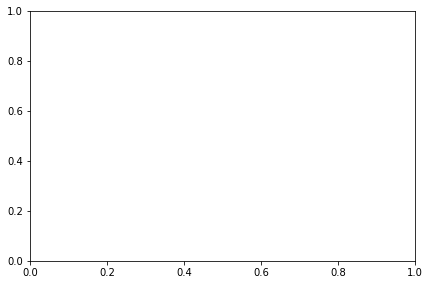

In [20]:
import os

colors = ['#E24A33', '#348ABD', '#FBC15E', '#8EBA42','#B118C8', '#988ED5', '#FFB5B8', '#777777', '#0BDEDA', '#078954', '#89072E', '#073C89']

fig2,ax2 = plt.subplots(figsize=(6.9, 4.6))
lines = []
# benchs = [f'miniIN1k_diversity_rank_{i}' for i in range(10)]
# benchs = [f'miniIN1k_val_acc_rank_{i}' for i in range(10)]#range(10)
benchs = [benchmark]#,'flower','cub'
# outDir = 'data/exp_class_selection_minmax/'
# outDir = 'data/exp_validation_acc/'
# outDir = 'data/exp_class_diversity_moco/'
# if not os.path.exists(outDir):
#     os.mkdir(outDir)
    
for bb, benchmark in enumerate(benchs):
    dset = get_dataset(benchmark, split='test')
    dset.transform = get_transform(phase='test')
    features, targets = get_dataset_features(dset, feat=feat)
    class_feats = get_class_mean_from_dset_features(features, targets)

    pdist = get_pdist(miniIN6k_feats, class_feats)
    vals, inds = pdist.sort()
    dist_to_bench = vals[:,0]
    
    ######  
    
    measures = torch.FloatTensor(measures_all)
    vals, inds = measures.sort() # sort by increasing diversity

    bins = 10
    sub = len(measures)//bins

    fig, ax = plt.subplots()
#     l = []
#     k = []

#     n = 1e8 # to keep minimum nb of classes verifying the condition

#     exp_inds = []
#     rand_inds = []

#     max_ = 1
#     for i in range(bins):
#         bin_inds = inds[sub*i:sub*i+sub]
#         x = dist_to_bench[bin_inds]
#         max_ = min(max_, x.sort()[0][-6].item()) 

#     print('max: ',max_)
#     min_ = max_
    
#     N = 100
#     for i in range(bins):
#         bin_inds = inds[sub*i:sub*i+sub]
#         x = dist_to_bench[bin_inds]

#         m = min_
#         c  = 0
#         step = 0.001
#         while len(torch.where( (x < max_) & (x > m) )[0]) < N:
#             m = m - step
#             if m < 0:
#                 break
#             if m < 0.:
#                 raise ValueError('Too close') 
#         min_ = min(min_, m)
    
#     print(min_, max_)

    for i in range(bins):
        bin_inds = inds[sub*i:sub*i+sub]
        x = dist_to_bench[bin_inds]
        ax.plot(range(sub*i,sub*i+sub), x.sort()[0], '.', markersize=1)

#         winds = torch.where( x > 0 )[0]
#         l.append(x[winds].mean())

#         winds = torch.where( (x < max_) & (x > min_) )[0]
#         print(winds.size())

#         k.append(x[winds].mean())
#         n = min(n, len(winds))

#         exp_inds.append(bin_inds[winds])
#         rand_inds.append(bin_inds)#
#     ax.plot([min_]*6000, color='black', label=f'min={round(min_,2)}', linestyle='dotted')
#     ax.plot([max_]*6000, color='black', label=f'max={round(max_,2)}', linestyle='--')

    # ax.plot(vals, color='black', label='Class diversity')
    x = 'class diversity' if measure == 'diversity' else 'validation performance'
    ax.set_xlabel(f'{len(measures_all)} classes divided into 10 bins of increasing {x}')
    ax.set_ylabel(f'Sorted min distance to {benchmark} test classes')
#     ax.legend()
    
#     ####

#     nc = 64
#     bins = 10
    
#     for seed in range(5):
#         INDS = deepcopy(exp_inds)
#         xx = torch.zeros(nc, bins).long()
#         yy = torch.zeros(nc, bins).long()
#         for j in  range(nc):
#             x = (max_-min_)*np.random.rand()+min_
#             for i in range(bins):
#                 min_ind = torch.argmin((dist_to_bench[INDS[i]] - x).abs())
#                 xx[j,i] = INDS[i][min_ind]
#                 INDS[i] = torch.cat([INDS[i][:min_ind], INDS[i][min_ind+1:]])
#         filename = outDir+f'{benchmark}_select_{nc}_classes_seed_{seed}.pth'
#         print(filename)
#         torch.save(xx, filename)
#         kk = []
#         for i in range(bins):
#             bin_inds = rand_inds[i]
#             yy[:,i] = bin_inds[torch.randperm(len(bin_inds))[:nc]]
#             kk.append(dist_to_bench[yy[:,i]].mean())
#         filename = outDir+f'{benchmark}_random_{nc}_classes_seed_{seed}.pth'
#         torch.save(yy, filename)

#     line, = ax2.plot([i for i in range(10)], l, color=colors[bb], linestyle='dotted')#, color='red', label=f'Original {benchmark}'
#     lines.append(line)
#     line, = ax2.plot([i for i in range(10)], k, color=colors[bb], linestyle='solid')#, color='blue', label=f'Selected  {benchmark}'
#     lines.append(line)
#     line, = ax2.plot([i for i in range(10)], kk, color=colors[bb], linestyle='dashed')#, color='blue', label=f'Selected  {benchmark}'
#     lines.append(line)
#     ax2.set_xlabel('6000 classes divided into 10 bins of increasing class diversity')##validation performance
#     ax2.set_ylabel('Similarity to test classes')
ax2.grid()

In [19]:
torch.cuda.empty_cache()

In [17]:
x_ = x.replace(' ','_')
fname = f'submitit_runs2/fig9/fig9_class_{x_}_similarity_correlation_{benchmark}.pdf'
fig.savefig(fname, format='pdf', bbox_inches="tight")
print(fname)
#diversity

submitit_runs2/fig9/fig9_class_validation_performance_similarity_correlation_cub.pdf


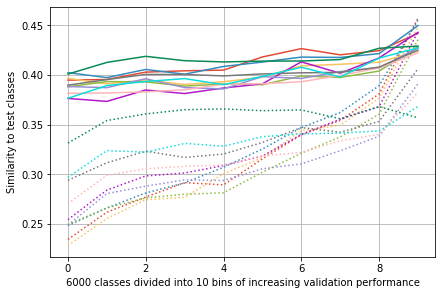

In [41]:
fig2

In [14]:
filename

'data/exp_validation_acc/cub_random_64_classes_seed_4.pth'

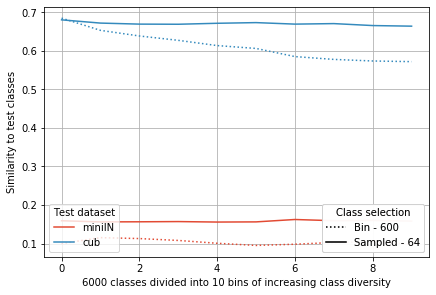

In [10]:
# benchs = ['miniIN','flower','cub']
from matplotlib.legend import Legend
legend1 = Legend(ax2, lines[1::2], benchs, loc=3, title='Test dataset', ncol=1)
ax2.add_artist(legend1)

legend2 = Legend(ax2, lines[:2], ['Bin - 600', 'Sampled - 64'], loc=4, title='Class selection')
ax2.add_artist(legend2)
for h in legend2.legendHandles:
    h.set_color('black')
fig2

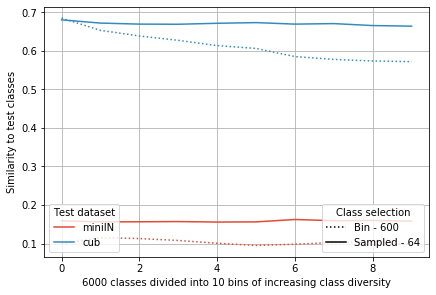

In [13]:
fig2

In [19]:

legend1 = Legend(ax2, lines[1::2], [x.split('_')[-1] for x in benchs], loc=3, title='MiniIN1k class diversity decile', ncol=5)#validation acc.
ax2.add_artist(legend1)

legend2 = Legend(ax2, lines[:2], ['Bin - 600', 'Sampled - 64'], loc=4, title='Class selection')
ax2.add_artist(legend2)
for h in legend2.legendHandles:
    h.set_color('black')


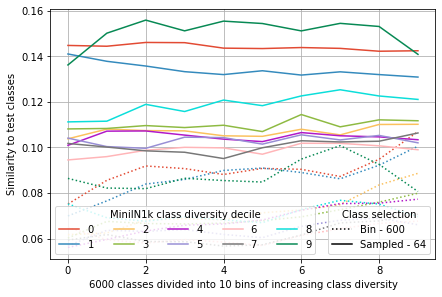

In [20]:
fig2

In [ ]:
fig2.savefig(outDir+f'fig2.pdf', format='pdf', bbox_inches="tight") 

In [18]:
legend1.remove()
legend2.remove()

In [37]:
# legend = [x for x in ax2.get_children() if 'Legend' in x.__class__.__name__][0]
# legend

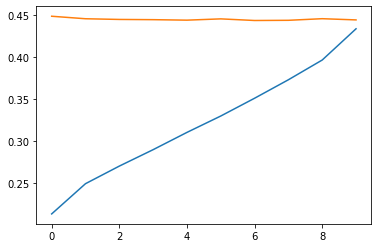

In [26]:
import torch
benchmark = 'miniIN'

dset = get_dataset(benchmark, split='test')
dset.transform = get_transform(phase='test')
features, targets = get_dataset_features(dset, feat='oracle')
class_feats_test = get_class_mean_from_dset_features(features, targets)


dset6k = get_dataset('miniIN6k')
xx = torch.load('data/exp_class_selection_minmax/select_64_classes_035_055_miniIN.pth')

seed = 0

nim = 38400//xx.size(0)
featvars = []
dist_testclasses = []
for rank in range(10):
    inds = xx[:,rank]
    dset = dset6k.sample_n_classes(class_inds=inds)
    dset = dset.sample_n_im_per_class(nim, seed=seed)
    dset.transform = get_transform(phase='test')
    features, targets = get_dataset_features(dset, feat='oracle')
    class_feats = get_class_mean_from_dset_features(features, targets)
    
    pdist = get_pdist(class_feats, class_feats_test)

    vals, inds = pdist.sort()

    dist_testclasses.append(vals[:,0].mean().item())
    
    
    class_featvar = []
    for j in targets.unique():
        f = features[targets==j]
        avg_feat = f.mean(0, keepdim=True)
        featvar = get_pdist(f, avg_feat).squeeze().mean().item()
        class_featvar.append(featvar)
     
    featvars.append(np.mean(class_featvar))
        


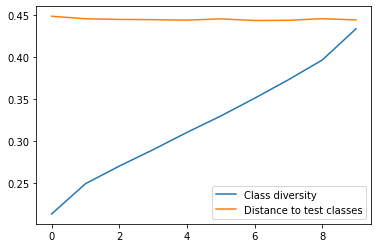

In [28]:
plt.plot(range(10), featvars, label='Class diversity')
plt.plot(range(10), dist_testclasses, label='Distance to test classes')
plt.legend()

In [33]:
import torch



In [36]:
miniIN1k_features['features'].size()

torch.Size([1281167, 640])

In [ ]:

def get_miniIN6k_validation_performance(feat='oracle'):
    model = Model(nClasses=1000, classifier_arch='cosine')
    miniIN1k_features = torch.load('data/exp_class_selection_minmax/miniIN1k_features.pth')
    if feat == 'oracle':
        pretrained_path = 'data/oracle_features/best_checkpoint.pth'
        print(f'Loading oracle weights from {pretrained_path}')
        model.load_state_dict(torch.load(pretrained_path)['model'])
    model = model.cuda().eval()
    vals = []
    for i in tqdm(range(6000)):
        cfeat = get_miniIN6k_features_of_class(i, feat=feat, normalize=False)
        with torch.no_grad():
            outs = model.fc(cfeat.cuda())
            correct = outs.sort()[1][:,-1] == i
            acc = float(sum(correct))/correct.size(0)
            vals.append(acc)
        
    return vals

# Rank IN1k classes by increasing class validation performance

In [22]:
import torch
from tqdm import tqdm
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import matplotlib.pyplot as plt


from torchvision.models import resnet50
model = resnet50(pretrained=True)

model = torch.nn.DataParallel(model).cuda().eval()

dset = ImageFolder('/datasets01/imagenet_full_size/061417/val/')
dset.transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

loader = torch.utils.data.DataLoader(dset, batch_size=1024, num_workers=16, shuffle=False, drop_last=False)

outputs = []
targets = []

for i, (ims, labels) in enumerate(tqdm(loader)):
    with torch.no_grad():
        outs = model(ims.cuda())
        outputs.append(outs.cpu())
        targets.append(labels)
        
outputs = torch.cat(outputs, dim=0)
targets = torch.cat(targets, dim=0)

vals = []
for target in targets.unique():
    outs = outputs[targets==target]
    correct = outs.sort()[1][:,-1] == target
    acc = float(sum(correct))/correct.size(0)
    vals.append(acc)

inds = np.argsort(vals)
torch.save(list(inds), 'data/exp_validation_acc/IN1k_classes_ranked_by_increasing_validation_acc_resnet50.pth')


In [23]:
plt.plot(sorted(vals),label='resnet50')
plt.plot(sorted(resnet18_vals), label='resnet18')
plt.ylabel('Class accuracy on IN1k val')
plt.legend()

In [33]:
import numpy as np
np.mean(vals)

0.7613000000000001

In [49]:
# save miniIN1k validation performance deciles
for rank, rank_inds in enumerate(torch.split(torch.from_numpy(inds), 100)):
    torch.save(rank_inds, f'data/exp_validation_acc/miniIN1k_val_acc_inds_rank_{rank}.pth')